## 原生入侵種淡水魚分析
### Native Invasive Fresh Water fish Analysis

 <p style="text-align:right">特生中心 研究助理 曾子榮 <p/>

### 前言 

台灣的原生淡水魚中，有數種目前已藉由人為放流至新棲地，且成功建立大量族群，影響當地原有的魚類。然而由於這些入侵物種是原生種，而非外來種，而受到較少的關注。<br/>我手邊剛好有一份為了出版淡水魚紅皮書而整理的資料，或許可以從這份資料去抓出一些端倪，呈現這個現象、釐清各地區進來的時間、入侵後的趨勢、以及或許對原有群聚的影響。

### 分析概要 

1. 轉換成努力量  ... DONE
2. 使用二項式分佈 ... ING
3. 推估可能的入侵時間
4. 視覺化


In [1]:
%matplotlib inline
import pandas as pd
import pysal as ps
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import numpy as np
import folium
from datetime import datetime
import os
from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
import time
import vincent, json

Roses are <span style="color:red">red</span>, violets are <span style="color:blue">blue</span>.
Roses are <span style="color:red; font-family:Georgia; font-size:2em;">red.</span>

In [85]:
DATA = pd.read_excel('2017-02-08_re_out_ALLGPS_mod.xlsx')

### Remove wierd names (sea water fishes??)
Name = pd.read_excel('FreshWaterFishNames.xlsx')
N = Name.iloc[:,0].tolist()
BOOL = [i in N for i in DATA.Scientific_name]
DATA = DATA[BOOL]

Polygons = ps.open('淡水魚分佈區\\CatchmentArea6_S_WGS84.shp').read()
print(DATA.head())
print(DATA.columns)

                Scientific_name  Latitude  Longitude  Year  Month  Source
63              Channa asiatica     25.18     121.45  1991      4  TAIBIF
64              Channa maculata     22.46     120.46  1990      8  TAIBIF
65  Chanodichthys erythropterus     23.18     120.35  1990      6  TAIBIF
66  Chanodichthys erythropterus     23.83     120.91  1991      1  TAIBIF
67                Chanos chanos     22.46     120.46  1990      7  TAIBIF
Index(['Scientific_name', 'Latitude', 'Longitude', 'Year', 'Month', 'Source'], dtype='object')


根據台灣淡水及河口魚類誌(陳等1999)，可將台灣劃分為六塊河川湖泊魚類動物地理區，如圖下

台灣石賓(Acrossocheilus paradoxus)原生I、II區，現已全台廣泛分布<br/>
何氏棘魞(Spinibarbus hollandi)原生III、V區，現已擴散到II、I區<br/>
粗首馬口鱲(Opsariichthys pachycephalus)原本東部(V區)沒有，現在已東部十分普遍<br/>
明潭吻鰕虎(Rhinogobius candidianus)入侵東部(V區)<br/>

In [62]:
m = folium.Map(location=[24, 121], zoom_start=7, tiles="Stamen Terrain")
# Polygons[i].vertices
# Polygons[i].centroid
for i,c in zip(range(5),['#ffffff','#00ff00','#ff0000','#0000ff','#000000',]):
    A = {"type": "FeatureCollection","features":\
          [{"type": "Feature","properties": {},"geometry":\
            {"type": "Polygon","coordinates": [Polygons[i].vertices]}}]}
    folium.GeoJson(A,name='geojson').add_to(m)
    m.choropleth(geo_str=A,fill_color=c,fill_opacity=0.3)
icon_url = ['https://image.flaticon.com/icons/svg/188/188253.svg',
           'https://image.flaticon.com/icons/svg/188/188254.svg',
           'https://image.flaticon.com/icons/svg/188/188255.svg',
           'https://image.flaticon.com/icons/svg/188/188256.svg',
           'https://image.flaticon.com/icons/svg/188/188257.svg']
    
for N in range(5):
    icon = folium.features.CustomIcon(icon_image=icon_url[N],icon_size=(30, 30))
    folium.Marker((Polygons[N].centroid[1],Polygons[N].centroid[0]),popup='Nothing', icon=icon).add_to(m)
m

In [3]:
def PIPC(LAT,LON,polygon):
    '''
    Check whether a vector of points(Lat,Lon) is inside a polygon
    Return a vector of BOOL
    '''
    crd = np.array(polygon)# poly
    bbPath = mplPath.Path(crd)
    pnts = [[i,j] for i,j in zip(LON,LAT)] # points
    r = 0.001 # accuracy
    isIn = [ bbPath.contains_point(pnt,radius=r) or bbPath.contains_point(pnt,radius=-r) for pnt in pnts]
    return isIn

def TEC(polygon,fishname='Acrossocheilus paradoxus',after=2010,before=2020):
    '''
    Total effort calculator & fish appearance calculator
    '''
    BOOL = np.array(DATA.Year<=before) & np.array(DATA.Year>=after)
    TMP = DATA[BOOL]
    
    TMP3 = TMP.drop_duplicates(subset=['Latitude','Longitude','Year','Month','Source'],keep='first')
    TE = sum(PIPC(TMP3.Latitude,TMP3.Longitude,polygon))
    # Calculate fish appearance
    TMP4 = TMP[TMP.Scientific_name==fishname].drop_duplicates(subset=['Latitude','Longitude','Year','Month','Source'],keep='first')
    FA = sum(PIPC(TMP4.Latitude,TMP4.Longitude,polygon))
    return (FA,TE)

In [4]:
def OUTTABLE(fishname='Acrossocheilus paradoxus',output=False):
    O = []
    for i,j in enumerate(['I','II','III','IV','V']):
        K = []
        K1 = []
        for Y in [[1800,1989],[1990,1995],[1996,2000],[2001,2002],[2003,2004],[2005,2006],[2007,2008],[2009,2010],[2011,2012],[2013,2020]]:
            TTT = TEC(Polygons[i].vertices,fishname=fishname,after = Y[0],before = Y[1])
            K.append(TTT[0])
            K1.append(TTT[1])
        O.append(pd.Series(K,name='R_'+j+'_FA'))
        O.append(pd.Series(K1,name='R_'+j+'_TE'))
    
    OUT = pd.DataFrame(O)
    OUT.columns = ['1800~1989','1990~1995','1996~2000','2001~2002','2003~2004','2005~2006','2007~2008','2009~2010','2011~2012','2013~']
    if output == True:        
        OUT.to_excel(str(datetime.now())[0:10]+'_'+fishname+'_Otable.xlsx')    
    print(fishname)
    return OUT

In [5]:
Ap = OUTTABLE('Acrossocheilus paradoxus')
Ap

Acrossocheilus paradoxus


,1800~1989,1990~1995,1996~2000,2001~2002,2003~2004,2005~2006,2007~2008,2009~2010,2011~2012,2013~
R_I_FA,28,17,109,32,331,232,33,85,6,27
R_I_TE,186,89,416,139,857,496,44,146,7,62
R_II_FA,6,27,113,130,389,179,163,159,124,34
R_II_TE,40,90,303,562,1151,594,365,439,181,55
R_III_FA,9,9,98,98,119,109,43,9,45,5
R_III_TE,113,75,427,633,533,505,174,159,266,185
R_IV_FA,0,0,0,0,2,0,0,1,26,0
R_IV_TE,23,11,47,70,136,1,10,29,35,4
R_V_FA,0,0,0,18,156,141,0,2,4,3
R_V_TE,30,40,11,54,529,342,6,51,41,111


In [6]:
Sh = OUTTABLE('Spinibarbus hollandi')
Sh

Spinibarbus hollandi


,1800~1989,1990~1995,1996~2000,2001~2002,2003~2004,2005~2006,2007~2008,2009~2010,2011~2012,2013~
R_I_FA,0,0,0,0,0,0,0,1,0,0
R_I_TE,186,89,416,139,857,496,44,146,7,62
R_II_FA,0,0,0,0,6,3,1,3,6,0
R_II_TE,40,90,303,562,1151,594,365,439,181,55
R_III_FA,3,0,1,10,13,24,11,12,15,2
R_III_TE,113,75,427,633,533,505,174,159,266,185
R_IV_FA,0,0,0,0,0,0,0,0,0,0
R_IV_TE,23,11,47,70,136,1,10,29,35,4
R_V_FA,1,1,3,9,45,38,0,9,4,8
R_V_TE,30,40,11,54,529,342,6,51,41,111


In [7]:
Op = OUTTABLE('Opsariichthys pachycephalus')
Op

Opsariichthys pachycephalus


,1800~1989,1990~1995,1996~2000,2001~2002,2003~2004,2005~2006,2007~2008,2009~2010,2011~2012,2013~
R_I_FA,15,27,76,26,284,163,2,36,5,6
R_I_TE,186,89,416,139,857,496,44,146,7,62
R_II_FA,6,16,73,205,520,286,178,201,106,19
R_II_TE,40,90,303,562,1151,594,365,439,181,55
R_III_FA,2,4,199,178,242,128,77,56,113,71
R_III_TE,113,75,427,633,533,505,174,159,266,185
R_IV_FA,0,0,0,30,33,0,0,0,27,0
R_IV_TE,23,11,47,70,136,1,10,29,35,4
R_V_FA,0,0,1,30,222,174,0,6,14,22
R_V_TE,30,40,11,54,529,342,6,51,41,111


In [8]:
Rc = OUTTABLE('Rhinogobius candidianus')
Rc

Rhinogobius candidianus


,1800~1989,1990~1995,1996~2000,2001~2002,2003~2004,2005~2006,2007~2008,2009~2010,2011~2012,2013~
R_I_FA,0,5,155,29,315,251,12,70,7,11
R_I_TE,186,89,416,139,857,496,44,146,7,62
R_II_FA,0,12,123,274,516,274,205,238,138,30
R_II_TE,40,90,303,562,1151,594,365,439,181,55
R_III_FA,0,0,204,126,199,147,96,73,98,54
R_III_TE,113,75,427,633,533,505,174,159,266,185
R_IV_FA,0,0,0,3,2,0,0,0,15,0
R_IV_TE,23,11,47,70,136,1,10,29,35,4
R_V_FA,0,0,0,14,71,43,0,1,8,0
R_V_TE,30,40,11,54,529,342,6,51,41,111


## You can't use tradition way to show CPUE, since the efforts differed too much!

ref: http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb

In [75]:
import pymc3 as pm

def posterior_FA_ratio( FA, TE,alpha=1,beta=1,U=False,UL=[0,1], samples = 20000):
    N = TE
    with pm.Model() as model:
        if U == True:
            FA_ratio = pm.Uniform("FA_ratio", UL[0], UL[1])
        else:
            FA_ratio = pm.Beta("FA_ratio", alpha, beta)
            
        observations = pm.Binomial( "obs",  N, FA_ratio, observed=FA)
        
        trace = pm.sample(samples, step=pm.Metropolis(),progressbar=False)
    
    burned_trace = trace[int(samples/4):]
    return burned_trace['FA_ratio']

### It seems the parametric way to give beta prior seting is the only solution
### But in my opinion this method is really dirty!!
def beta_with_fixed_mu_sd(mu,sd):
    alpha = ((1.-mu)/sd*2 - 1./mu)*mu**2
    beta = alpha *(1. /mu -1.)
    return [alpha,beta]

### About the modeling
I use **informative priors** to model the detection rate based on binomial distribution. The priors came from the posterior of detection rate at the last time period. For time period 1, I use uniform (0,1), a uninformative setting. For time period 2 to end, I use the mean (I call this mean as $\mu$) and std from the posterior of detection rate (at T - 1), and re-parameterize them into alpha, beta for BETA distribution. Besides, some numeric error would arise becasue of the $\mu$ is too small. I just arbitrarily add a condition to fix it. Here it is: If $\mu$[T - 1] <= 0.001, Use prior Uniform(0,0.1). <br\> 
For **extreme event** in this data, I use uniform (0,1). Here is my definition for extreme event: If $\mu$[T-1]*5 < FA[T]/TE[T]. It's just another arbitrary definition. I assume the detection rate now should not be 5 times greater than last time.

In [79]:
def Run_N_Show(FA,TE,Name):
    OFAR = []
    for i in range(len(FA)):
        if i ==0:
            print('T = 1: USE Un-informative prior')
            OFAR.append(posterior_FA_ratio(FA[i],TE[i]))
        else:
            a,b = beta_with_fixed_mu_sd(OFAR[i-1].mean(),OFAR[i-1].std())
            if OFAR[i-1].mean()<=0.001:
                print('T = '+str(i+1)+': Posterior of mu[T-1] is too small, USE uniform(0,0.1) as informative prior')
                OFAR.append(posterior_FA_ratio(FA[i],TE[i],U=True,UL=(0,0.1)))
            elif OFAR[i-1].mean()*5 < FA[i]/TE[i]:
                print('T = '+str(i+1)+': Extreme event appear!, USE Un-informative prior!')
                OFAR.append(posterior_FA_ratio(FA[i],TE[i],alpha=1,beta=1))
            else:
                print('T = '+str(i+1)+': Use informative prior (T-1)')
                OFAR.append(posterior_FA_ratio(FA[i],TE[i],alpha=a,beta=b))

    DD = np.array(OFAR).T

    plt.figure(figsize=(12,8))
    plt.boxplot(DD)
    plt.title(Name,fontweight='bold',fontsize=16)
    plt.xticks(range(1,11),['1800~1989','1990~1995','1996~2000','2001~2002','2003~2004','2005~2006','2007~2008','2009~2010','2011~2012','2013~'],rotation='vertical')
    for i in range(10):
        plt.text(0.8+i,0.9,str(FA[i])+'/'+str(TE[i]),fontsize=12,color='#F92727')
    plt.ylim(0,1)
    plt.ylabel('Detection rate',fontsize=16)
    plt.show()

T = 1: USE Un-informative prior
T = 2: Use informative prior (T-1)
T = 3: Use informative prior (T-1)
T = 4: Use informative prior (T-1)
T = 5: Use informative prior (T-1)
T = 6: Use informative prior (T-1)
T = 7: Use informative prior (T-1)
T = 8: Use informative prior (T-1)
T = 9: Use informative prior (T-1)
T = 10: Use informative prior (T-1)


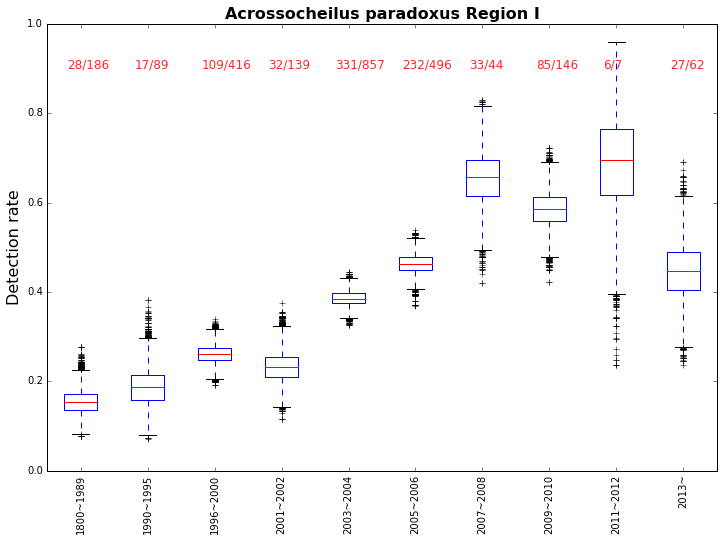

In [80]:
Run_N_Show(Ap.iloc[0],Ap.iloc[1],'Acrossocheilus paradoxus Region I')

T = 1: USE Un-informative prior
T = 2: Use informative prior (T-1)
T = 3: Use informative prior (T-1)
T = 4: Use informative prior (T-1)
T = 5: Use informative prior (T-1)
T = 6: Use informative prior (T-1)
T = 7: Use informative prior (T-1)
T = 8: Use informative prior (T-1)
T = 9: Use informative prior (T-1)
T = 10: Use informative prior (T-1)


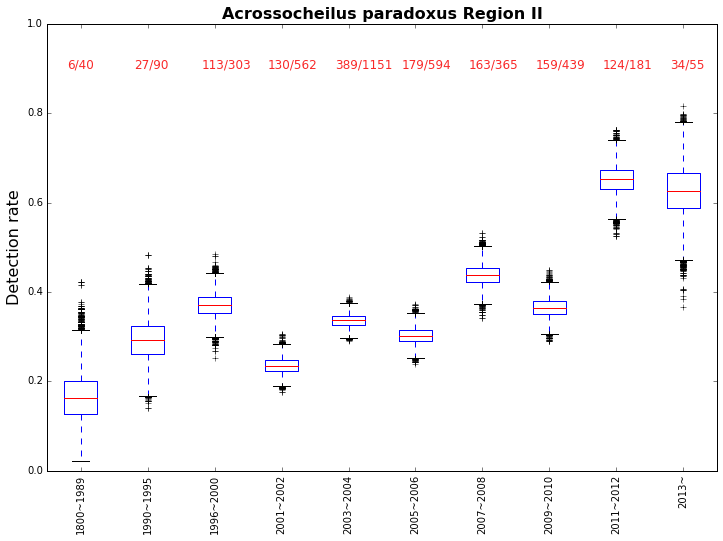

In [81]:
Run_N_Show(Ap.iloc[2],Ap.iloc[3],'Acrossocheilus paradoxus Region II')

T = 1: USE Un-informative prior
T = 2: Use informative prior (T-1)
T = 3: Use informative prior (T-1)
T = 4: Use informative prior (T-1)
T = 5: Use informative prior (T-1)
T = 6: Use informative prior (T-1)
T = 7: Use informative prior (T-1)
T = 8: Use informative prior (T-1)
T = 9: Use informative prior (T-1)
T = 10: Use informative prior (T-1)


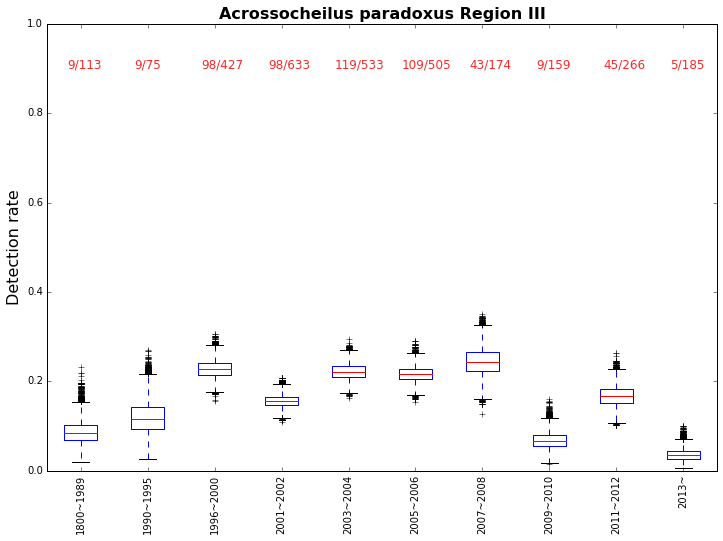

In [82]:
Run_N_Show(Ap.iloc[4],Ap.iloc[5],'Acrossocheilus paradoxus Region III')

T = 1: USE Un-informative prior
T = 2: Use informative prior (T-1)
T = 3: Use informative prior (T-1)
T = 4: Use informative prior (T-1)
T = 5: Use informative prior (T-1)
T = 6: Use informative prior (T-1)
T = 7: Use informative prior (T-1)
T = 8: Posterior of mu[T-1] is too small, USE uniform(0,0.1) as informative prior
T = 9: Extreme event appear!, USE Un-informative prior!
T = 10: Use informative prior (T-1)


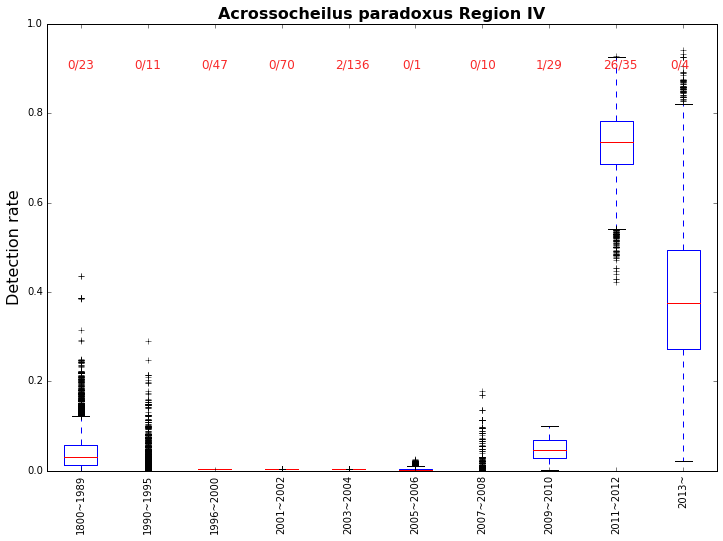

In [83]:
Run_N_Show(Ap.iloc[6],Ap.iloc[7],'Acrossocheilus paradoxus Region IV')

T = 1: USE Un-informative prior
T = 2: Use informative prior (T-1)
T = 3: Posterior of mu[T-1] is too small, USE uniform(0,0.1) as informative prior
T = 4: Extreme event appear!, USE Un-informative prior!
T = 5: Use informative prior (T-1)
T = 6: Use informative prior (T-1)
T = 7: Use informative prior (T-1)
T = 8: Use informative prior (T-1)
T = 9: Use informative prior (T-1)
T = 10: Use informative prior (T-1)


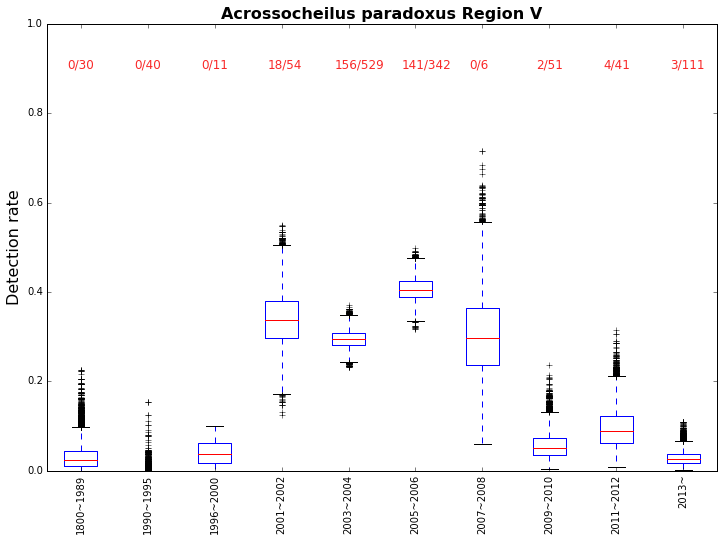

In [84]:
Run_N_Show(Ap.iloc[8],Ap.iloc[9],'Acrossocheilus paradoxus Region V')

**This problem should be resulted from very small 'mu'. Such that Inf result of alpha and beta pop up. Maybe a better setting would be: if mu[T-1] <= 0.001?, use uniform(0,0.1)?? and if mu[T-1] << than FA/TE, use uniform(0,1)?**

In [86]:
## Reference Code to embed folium map on jupyter
import vincent, json
import numpy as np
import folium

scatter_points = {
    'x' : np.random.uniform(size=(100,)),
    'y' : np.random.uniform(size=(100,)),
    }

# Let's create the vincent chart.
scatter_chart = vincent.Scatter(scatter_points,
                                iter_idx='x',
                                width=600,
                                height=300)

# Let's convert it to JSON.
scatter_json = scatter_chart.to_json()

# Let's convert it to dict.
scatter_dict = json.loads(scatter_json)

m = folium.Map([43,-100], zoom_start=4)

# Let's create a Vega popup based on scatter_chart.
popup = folium.Popup(max_width=800)
folium.Vega(scatter_chart, height=350, width=650).add_to(popup)
folium.Marker([30,-120], popup=popup).add_to(m)

# Let's create a Vega popup based on scatter_json.
popup = folium.Popup(max_width=800)
folium.Vega(scatter_json, height=350, width=650).add_to(popup)
folium.Marker([30,-100], popup=popup).add_to(m)

# Let's create a Vega popup based on scatter_dict.
popup = folium.Popup(max_width=800)
folium.Vega(scatter_dict, height=350, width=650).add_to(popup)    
folium.Marker([30,-80], popup=popup).add_to(m)

m

In [74]:
help(pm.sample)

Help on function sample in module pymc3.sampling:

sample(draws, step=None, init='advi', n_init=200000, start=None, trace=None, chain=0, njobs=1, tune=None, progressbar=True, model=None, random_seed=-1)
    Draw a number of samples using the given step method.
    Multiple step methods supported via compound step method
    returns the amount of time taken.
    
    Parameters
    ----------
    
    draws : int
        The number of samples to draw.
    step : function or iterable of functions
        A step function or collection of functions. If no step methods are
        specified, or are partially specified, they will be assigned
        automatically (defaults to None).
    init : str {'advi', 'advi_map', 'map', 'nuts', None}
        Initialization method to use.
        * advi : Run ADVI to estimate posterior mean and diagonal covariance matrix.
        * advi_map: Initialize ADVI with MAP and use MAP as starting point.
        * map : Use the MAP as starting point.
        * n

In [54]:
url_base = 'http://vignette3.wikia.nocookie.net/'
url_folder = 'the-adventures-of-the-gladiators-of-cybertron/'
url_file = 'images/6/67/Iron_Man.png/revision/latest?cb=20140720074813'
logo_url = url_base + url_folder + url_file
UCB_lat = 37.8719
UCB_lon = -122.2585

map_1 = folium.Map(location=[UCB_lat, UCB_lon], zoom_start=12,\
                      control_scale = True, tiles='Stamen Terrain')

icon = folium.features.CustomIcon(logo_url,\
                                  icon_size=(200, 200))

folium.Marker([UCB_lat, UCB_lon],
          popup='Iron man visit Berkeley',
          icon=icon).add_to(map_1)

map_1

In [ ]:
## I can change the css style based on web references by the folowing code

# url_1:http://kevinburke.bitbucket.org/markdowncss/markdown.css
# url_2:https://raw.githubusercontent.com/titipata/klab_ipython_notebook/master/custom.css
# import requests
# from IPython.core.display import HTML
# link = requests.get("https://raw.githubusercontent.com/titipata/klab_ipython_notebook/master/custom.css")
# HTML("<style>"+link.content.decode()+"</style>")

In [77]:
# Let's create a Figure, with a map inside.
f = folium.element.Figure()
folium.Map([-25,150], zoom_start=3).add_to(f)

# Let's put the figure into an IFrame.
iframe = folium.element.IFrame(width=500, height=300)
f.add_to(iframe)

# Let's put the IFrame in a Popup
popup = folium.Popup(iframe, max_width=2650)

# Let's create another map.
m = folium.Map([43,-100], zoom_start=4)

# Let's put the Popup on a marker, in the second map.
folium.Marker([30,-100], popup=popup).add_to(m)

# We get a map in a Popup. Not really useful, but powerful.
m